In [18]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# standard imports
import tensorrt #For GPU
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
import random
from sklearn import preprocessing
from keras.callbacks import History
import matplotlib.pyplot as plt
import np_utils
import os
from tensorflow.keras.optimizers import Adam
from plain_neural_network import*
from keras import backend as K

%matplotlib inline

In [19]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 56344699698743468
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 82781208576
locality {
  bus_id: 4
  numa_node: 3
  links {
  }
}
incarnation: 10070873136231119361
physical_device_desc: "device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:01:00.0, compute capability: 8.0"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-10-21 16:44:19.863051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 78946 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:01:00.0, compute capability: 8.0


In [20]:
input_dir = "/albedo/home/ssunar/CNN_eddy_detection/for_paper/interpolation/south_atlantic"
input_file_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
    ])
#input_file_paths.pop(29)
#input_file_paths.pop(11)

data_x = xr.open_mfdataset(input_file_paths,combine = 'nested', concat_dim="TIME")
data_x = data_x.ssh.to_numpy()
X = np.float32(data_x)
                            
X[X>1000] = 0
print(X.shape)

(1905, 840, 480)


In [21]:
input_dir = "/albedo/home/ssunar/CNN_eddy_detection/for_paper/segmentation_masks/south_atlantic"
input_file_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
    ])
#input_file_paths.pop(29)
#input_file_paths.pop(11)

data_y = xr.open_mfdataset(input_file_paths,combine = 'nested', concat_dim="TIME")
data_y = data_y.seg_mask.to_numpy()
Y = np.float32(data_y)


(Y.shape)

(1905, 840, 480)

In [22]:
Y[(Y != 1) & (Y!=2)] = 0

In [23]:
def split_3d_vector(vector):
    X, Y, Z = vector.shape
    chunks = []
    
    for i in range(X):
        vector_2d = vector[i,:,:]
        B = Y // 256 + 1
        for b in range(B):
            start_y = b * 256
            end_y = (b + 1) * 256
            if end_y > Y:
                start_y = Y - 256
                end_y = Y
      
            C = Z // 256 + 1
            for c in range(C):
                start_z = c * 256
                end_z = (c + 1) * 256
                if end_z > Z:
                    start_z = Z - 256
                    end_z = Z
                final_chunk = vector_2d[start_y:end_y, start_z:end_z]
                chunks.append(final_chunk)
    return chunks

In [24]:
new_X = np.array(split_3d_vector(X))
new_Y = np.array(split_3d_vector(Y))

data_x = new_X
data_y = new_Y

(data_x.shape)
(data_y.shape)

(15240, 256, 256)

(15240, 256, 256)

In [25]:
img_size = (256, 256)
num_classes = 3
batch_size = 16
epochs = 60
if len(data_x) > 4000:
    total_samples = 4000
else:
    total_samples = len(data_x)
print(total_samples)

4000


In [26]:
model = get_model(img_size, num_classes)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 separable_conv2d_15 (Separ  (None, 256, 256, 16)         25        ['input_2[0][0]']             
 ableConv2D)                                                                                      
                                                                                                  
 batch_normalization_14 (Ba  (None, 256, 256, 16)         64        ['separable_conv2d_15[0][0]'] 
 tchNormalization)                                                                                
                                                                                            

 separable_conv2d_22 (Separ  (None, 32, 32, 32)           1312      ['activation_21[0][0]']       
 ableConv2D)                                                                                      
                                                                                                  
 batch_normalization_21 (Ba  (None, 32, 32, 32)           128       ['separable_conv2d_22[0][0]'] 
 tchNormalization)                                                                                
                                                                                                  
 activation_22 (Activation)  (None, 32, 32, 32)           0         ['batch_normalization_21[0][0]
                                                                    ']                            
                                                                                                  
 dropout_10 (Dropout)        (None, 32, 32, 32)           0         ['activation_22[0][0]']       
          

                                                                                                  
 activation_28 (Activation)  (None, 256, 256, 16)         0         ['batch_normalization_27[0][0]
                                                                    ']                            
                                                                                                  
 dropout_13 (Dropout)        (None, 256, 256, 16)         0         ['activation_28[0][0]']       
                                                                                                  
 separable_conv2d_29 (Separ  (None, 256, 256, 3)          64        ['dropout_13[0][0]']          
 ableConv2D)                                                                                      
                                                                                                  
 reshape_1 (Reshape)         (None, 65536, 3)             0         ['separable_conv2d_29[0][0]'] 
          

In [27]:
#Loss function 
#defined from the paper:
#Santana et al._2020_Neural network training for the detection and classification of oceanic mesoscale eddies

unique, counts = np.unique(data_y, return_counts=True)
dict(zip(unique, counts))

freq = [np.sum(counts)/j for j in counts]
weightsSeg = [f/np.sum(freq) for f in freq]
print(weightsSeg)

def dice_coef_anti(y_true, y_pred):
    smooth = 1.  # to avoid zero division
    y_true_anti = y_true[:,:,1]
    y_pred_anti = y_pred[:,:,1]
    intersection_anti = K.sum(y_true_anti * y_pred_anti)
    return (2 * intersection_anti + smooth) / (K.sum(y_true_anti)+ K.sum(y_pred_anti) + smooth)

def dice_coef_cyc(y_true, y_pred):
    smooth = 1.  # to avoid zero division
    y_true_cyc = y_true[:,:,2]
    y_pred_cyc = y_pred[:,:,2]
    intersection_cyc = K.sum(y_true_cyc * y_pred_cyc)
    return (2 * intersection_cyc + smooth) / (K.sum(y_true_cyc) + K.sum(y_pred_cyc) + smooth)

def dice_coef_nn(y_true, y_pred):
    smooth = 1.  # to avoid zero division
    y_true_nn = y_true[:,:,0]
    y_pred_nn = y_pred[:,:,0]
    intersection_nn = K.sum(y_true_nn * y_pred_nn)
    return (2 * intersection_nn + smooth) / (K.sum(y_true_nn) + K.sum(y_pred_nn) + smooth)
    
def mean_dice_coef(y_true, y_pred):
    return (dice_coef_anti(y_true, y_pred) + dice_coef_cyc(y_true, y_pred) + dice_coef_nn(y_true, y_pred))/3.

def weighted_mean_dice_coef(y_true, y_pred):
    #return (weightsSeg[2]*dice_coef_anti(y_true, y_pred) + weightsSeg[1]*dice_coef_cyc(y_true, y_pred) + weightsSeg[0]*dice_coef_nn(y_true, y_pred))
    return (weightsSeg[2]*dice_coef_anti(y_true, y_pred) + weightsSeg[1]*dice_coef_cyc(y_true, y_pred) + weightsSeg[0]*dice_coef_nn(y_true, y_pred))
      
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_mean_dice_coef(y_true, y_pred)

{0.0: 910443743, 1.0: 40704538, 2.0: 47620359}

[0.023537207665551153, 0.5264598125838619, 0.450002979750587]


In [28]:
# Split our img paths into a training and a validation set
split = 0.3
train_samples = int((1-split)*total_samples)
#same seed must be used
random.Random(0).shuffle(data_x)
random.Random(0).shuffle(data_y)
train_input = data_x[0:train_samples]
train_target = data_y[0:train_samples]
val_input = data_x[train_samples:total_samples]
val_target = data_y[train_samples:total_samples]

print("train_input:", train_input.shape)
print("val_input:", val_input.shape)

# Instantiate data Sequences for each split
train_gen = plain_net_eddy(batch_size, img_size, train_input, train_target)
val_gen = plain_net_eddy(batch_size, img_size, val_input, val_target)
print("Size of each batch: ",train_gen[1][0].shape)

train_input: (2800, 256, 256)
val_input: (1200, 256, 256)
Size of each batch:  (16, 256, 256, 1)


In [31]:
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/albedo/soft/sw/spack-sw/cuda/11.7.0-qk7q7bh/'
os.environ['XLA_FLAGS']
# print(os.environ.get('CUDA_HOME'))

'--xla_gpu_cuda_data_dir=/albedo/soft/sw/spack-sw/cuda/11.7.0-qk7q7bh/'

In [32]:
file_path_save = "/albedo/home/ssunar/CNN_eddy_detection/for_paper/unet_trained/south_atlantic/train"
os.makedirs(file_path_save, exist_ok=True)
model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=['categorical_accuracy', mean_dice_coef, weighted_mean_dice_coef])

callbacks = [keras.callbacks.ModelCheckpoint(file_path_save, save_best_only=True , monitor='val_loss',save_weights_only=True, save_freq="epoch"),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)]

# Train the model, doing validation at the end of each epoch.
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks, shuffle=True,verbose=1)

Epoch 1/60


2023-10-21 16:49:50.353754: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-21 16:49:52.323724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-10-21 16:50:01.503528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-21 16:50:02.157323: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x15501aab7410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-21 16:50:02.157349: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-10-21 16:50:02.161861: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.c

175/175 [==============================] - 38s 104ms/step - loss: 0.8514 - categorical_accuracy: 0.6954 - mean_dice_coef: 0.2730 - weighted_mean_dice_coef: 0.1486 - val_loss: 0.9274 - val_categorical_accuracy: 0.9131 - val_mean_dice_coef: 0.2626 - val_weighted_mean_dice_coef: 0.0726 - lr: 0.0010
Epoch 2/60
175/175 [==============================] - 17s 99ms/step - loss: 0.6681 - categorical_accuracy: 0.8193 - mean_dice_coef: 0.4848 - weighted_mean_dice_coef: 0.3319 - val_loss: 0.9605 - val_categorical_accuracy: 0.9132 - val_mean_dice_coef: 0.3253 - val_weighted_mean_dice_coef: 0.0395 - lr: 0.0010
Epoch 3/60
175/175 [==============================] - 18s 101ms/step - loss: 0.5048 - categorical_accuracy: 0.9024 - mean_dice_coef: 0.6351 - weighted_mean_dice_coef: 0.4952 - val_loss: 0.8702 - val_categorical_accuracy: 0.9160 - val_mean_dice_coef: 0.3903 - val_weighted_mean_dice_coef: 0.1298 - lr: 0.0010
Epoch 4/60
175/175 [==============================] - 18s 101ms/step - loss: 0.4540 - ca

Epoch 28/60
175/175 [==============================] - 17s 99ms/step - loss: 0.3183 - categorical_accuracy: 0.9410 - mean_dice_coef: 0.7719 - weighted_mean_dice_coef: 0.6817 - val_loss: 0.4458 - val_categorical_accuracy: 0.9348 - val_mean_dice_coef: 0.6836 - val_weighted_mean_dice_coef: 0.5542 - lr: 0.0010
Epoch 29/60
175/175 [==============================] - 17s 100ms/step - loss: 0.3196 - categorical_accuracy: 0.9407 - mean_dice_coef: 0.7708 - weighted_mean_dice_coef: 0.6804 - val_loss: 0.5147 - val_categorical_accuracy: 0.9321 - val_mean_dice_coef: 0.6362 - val_weighted_mean_dice_coef: 0.4853 - lr: 0.0010
Epoch 30/60
175/175 [==============================] - 17s 99ms/step - loss: 0.3153 - categorical_accuracy: 0.9415 - mean_dice_coef: 0.7740 - weighted_mean_dice_coef: 0.6847 - val_loss: 0.4969 - val_categorical_accuracy: 0.9354 - val_mean_dice_coef: 0.6499 - val_weighted_mean_dice_coef: 0.5031 - lr: 0.0010
Epoch 31/60
175/175 [==============================] - 17s 99ms/step - loss

Epoch 54/60
175/175 [==============================] - 17s 100ms/step - loss: 0.2897 - categorical_accuracy: 0.9465 - mean_dice_coef: 0.7925 - weighted_mean_dice_coef: 0.7103 - val_loss: 0.4208 - val_categorical_accuracy: 0.9402 - val_mean_dice_coef: 0.7019 - val_weighted_mean_dice_coef: 0.5792 - lr: 5.0000e-04
Epoch 55/60
175/175 [==============================] - 17s 100ms/step - loss: 0.2893 - categorical_accuracy: 0.9466 - mean_dice_coef: 0.7927 - weighted_mean_dice_coef: 0.7107 - val_loss: 0.3907 - val_categorical_accuracy: 0.9435 - val_mean_dice_coef: 0.7231 - val_weighted_mean_dice_coef: 0.6093 - lr: 5.0000e-04
Epoch 56/60
175/175 [==============================] - ETA: 0s - loss: 0.2886 - categorical_accuracy: 0.9467 - mean_dice_coef: 0.7933 - weighted_mean_dice_coef: 0.7114
Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
175/175 [==============================] - 18s 100ms/step - loss: 0.2886 - categorical_accuracy: 0.9467 - mean_dice_coef: 0.7933 

In [67]:
model.save_weights(file_path_save + '/weights.h5')

<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

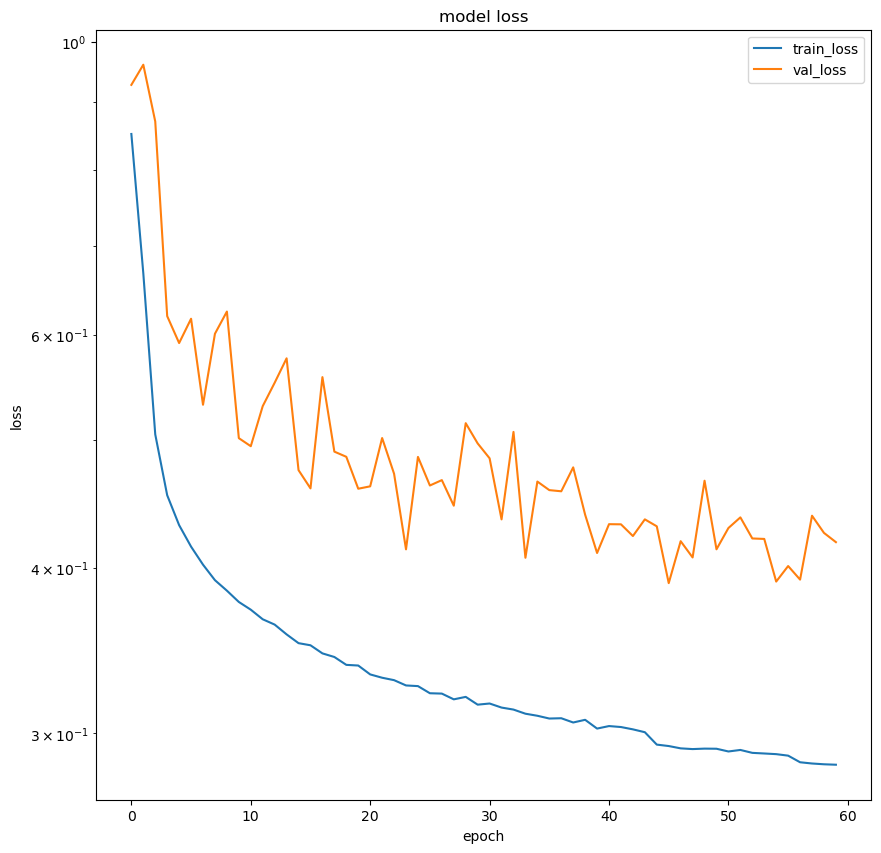

In [34]:
dir_path = "/albedo/home/ssunar/CNN_eddy_detection/for_paper/unet_trained/south_atlantic/train"
plt.figure(figsize=(10, 10))
plt.semilogy(model.history.history['loss'])
plt.semilogy(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right');
plt.savefig(dir_path + "loss_graph.png", dpi = 300)

In [35]:
import time
from sklearn.metrics import classification_report
start = time.time()
val_gen = plain_net_eddy(batch_size, img_size, val_input, val_target)
val_preds = model.predict(val_gen)
print(val_preds.shape)

end = time.time()
time_per_img = (end - start)/438
print("Time Per image:",time_per_img)
print("Time for 1 year eqv:",time_per_img*365)

75/75 [==============================] - 2s 18ms/step
(1200, 65536, 3)
Time Per image: 0.00450103794603043
Time for 1 year eqv: 1.6428788503011067


In [54]:
# Since we do not use all samples for training.
if len(data_x) > total_samples + 1000:
    test_size = 1000
    test_inp = data_x[total_samples : total_samples+test_size]
    test_seg = data_y[total_samples : total_samples+test_size]
elif len(data_x) > total_samples:
    test_size = len(data_x) - total_samples
    test_inp = data_x[total_samples : total_samples+test_size]
    test_seg = data_y[total_samples : total_samples+test_size]
else:
    test_inp = val_input
    test_seg = val_target
    test_size = len(test_inp)
    
test_inp.shape
test_seg.shape

(1000, 256, 256)

(1000, 256, 256)

In [112]:
# convert test segmentation mask into catagorical form
categorical_test_seg = to_categorical(test_seg)
categorical_test_seg.shape

(1000, 65536, 3)

In [115]:
# Model evaluation in test data in South Atlantic region
model.evaluate(test_inp, categorical_test_seg)

32/32 [==============================] - 1s 20ms/step - loss: 0.4305 - categorical_accuracy: 0.9431 - mean_dice_coef: 0.6962 - weighted_mean_dice_coef: 0.5695


[0.43049925565719604,
 0.9431262016296387,
 0.6962056756019592,
 0.5694870352745056]

In [117]:
# Prediction on test data
test_inp = np.reshape(test_inp,(len(test_inp),img_size[0],img_size[1],1))
catagorical_test_preds = model.predict(test_inp)

32/32 [==============================] - 0s 14ms/step


In [118]:
# Calculate confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    labels=tf.argmax(categorical_test_seg, axis=1),
    predictions=tf.argmax(catagorical_test_preds, axis=1),
    num_classes=3
)

# Calculate class-wise accuracy
class_wise_accuracy = tf.linalg.tensor_diag_part(confusion_mtx) / tf.reduce_sum(confusion_mtx, axis=1)

print("Confusion Matrix:")
print(confusion_mtx.numpy())
print("\nClass-wise Accuracy:")
print(class_wise_accuracy.numpy())

InvalidArgumentError: `labels` out of bound
Condition x < y did not hold.
First 3 elements of x:
[  0  99 111]
First 1 elements of y:
[3]

<Figure size 2000x1000 with 0 Axes>

<AxesSubplot:>

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'Result Segmentation')

<AxesSubplot:>

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'Groundtruth Segmentation')

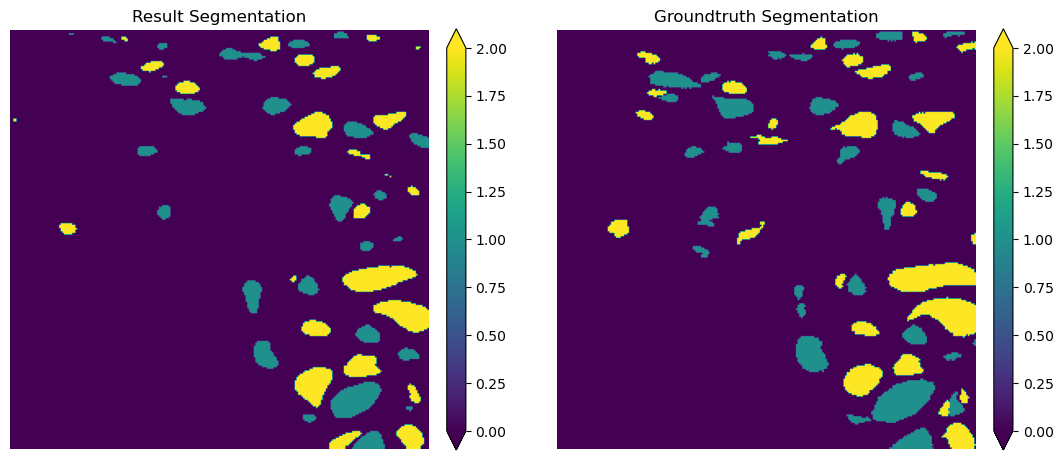

In [40]:
#seeing the prediction of one image of the validation set
%matplotlib inline

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(mask.T, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
plt.axis('off')
plt.title('Result Segmentation');
plt.savefig(dir_path + "prediction.png", dpi = 300)

plt.subplot(132)
plt.imshow(data_y[20].T, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
plt.axis('off')
plt.title('Groundtruth Segmentation');
plt.savefig(dir_path + "groundtruth.png", dpi = 300)